# A/B Testing Simulation

On this project, I'm trying to understand how changes on a website affected the number of clicks in different elements of the page. 

Through A/B Testing I'll be able to say which website will attract more clicks.

In [1]:
#Import libraries!
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LinearRegression
from regressors import stats

plt.style.use('ggplot')
%matplotlib inline

random.seed(100)

We have 5 versions of the website: A, B, C, D and E. In each file I have the total number of clicks on each element of the website. In addition, we also have a file with total visits by version of the website. 

Initially, we'll be analyzing how each one performed with the changes that were implemented.

In order to do that, all files will be imported and merged into one dataframe.

In [2]:
#Filepaths
a_file = './Interact - A.csv'
b_file = './Connect - B.csv'
c_file = './Learn - C.csv'
d_file = './Help - D.csv'
e_file = './Services - E.csv'

#Creating dataframes
df_A = pd.read_csv(a_file)
df_B = pd.read_csv(b_file)
df_C = pd.read_csv(c_file)
df_D = pd.read_csv(d_file)
df_E = pd.read_csv(e_file)

#Dropping last column, we don't actually need it.
df_A.drop(df_A.columns[-1], axis=1, inplace=True)
df_B.drop(df_B.columns[-1], axis=1, inplace=True)
df_C.drop(df_C.columns[-1], axis=1, inplace=True)
df_D.drop(df_D.columns[-1], axis=1, inplace=True)
df_E.drop(df_E.columns[-1], axis=1, inplace=True)

#Create identifier to differentiate versions.
df_A['sample_ID'] = 'A'
df_B['sample_ID'] = 'B'
df_C['sample_ID'] = 'C'
df_D['sample_ID'] = 'D'
df_E['sample_ID'] = 'E'

#Total visits dataframe - Manually created, extracted from a PDF report.
total_visits = [['A', 10283], ['B', 2742], ['C', 2747],['D',3180],['E',2064]]
visits = pd.DataFrame(total_visits,columns=['sample_ID','visits'])

#Create master file - Merge all dataframes.
df_list = [df_A,df_B,df_C,df_D,df_E]
df_master = pd.concat(df_list)
df_master = pd.merge(df_master,visits,on='sample_ID',how='left')

#Let's take a look
df_master.head()

,Element ID,Tag name,Name,No. clicks,Visible?,sample_ID,visits
0,128,area,Montana State University - Home,1291,False,A,10283
1,69,a,Buy,842,True,A,10283
2,61,input,Read more,508,True,A,10283
3,67,a,lib.montana.edu/find/,166,True,A,10283
4,78,a,REQUEST,151,True,A,10283


Okay, before we dive into it, we need to review what we have, I want to make sure that there's no null/odd values, if that's the case, then we'll have to make the appropriate updates.

In [3]:
#EDA
df_master.info() #No null values!!
df_master.describe()
df_master.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 298
Data columns (total 7 columns):
Element ID    299 non-null int64
Tag name      299 non-null object
Name          299 non-null object
No. clicks    299 non-null int64
Visible?      299 non-null bool
sample_ID     299 non-null object
visits        299 non-null int64
dtypes: bool(1), int64(3), object(3)
memory usage: 16.6+ KB


Element ID     int64
Tag name      object
Name          object
No. clicks     int64
Visible?        bool
sample_ID     object
visits         int64
dtype: object

Everything looks good to me, we're good to start analyzing what we have here.

Unfortunately, we don't have access to the data by user, the dataframe is indexed by element with total number of clicks.

Therefore, we'll have to create some assumptions here, first the Conversion Rate will be calculated by doing the following:
   - Conversion Rate = Total Number of Clicks for the element on the page / Total Number of page visits 
   
Another assumption to be made is that users only clicked once on each element, so there's no double-counting, every click in unique. This might not be the best way of analyzing conversion, but since we don't have the necessary data, we'll work with what we have. Besides, most of the time we're analyzing something we are making assumptions, so let's keep going!

In [4]:
#Okay, create conversion rate.
df_master['conversion_rate'] = (df_master['No. clicks']/df_master['visits'])*100
df_master.head(10)

,Element ID,Tag name,Name,No. clicks,Visible?,sample_ID,visits,conversion_rate
0,128,area,Montana State University - Home,1291,False,A,10283,12.554702
1,69,a,Buy,842,True,A,10283,8.188272
2,61,input,Read more,508,True,A,10283,4.940193
3,67,a,lib.montana.edu/find/,166,True,A,10283,1.614315
4,78,a,REQUEST,151,True,A,10283,1.468443
5,98,a,Explore,102,True,A,10283,0.991928
6,62,button,Search,101,True,A,10283,0.982204
7,118,a,MSU,55,True,A,10283,0.534863
8,50,span,nav-item-dot,46,True,A,10283,0.447340
9,87,a,INTERACT,42,True,A,10283,0.408441


As soon as I started playing with the data, I noticed that 'Element ID' is not accurate across different pages, the ID is unique for the page, but 'Name' and 'Tag Name' can be completely different. 

However, 'Name' seems to be more consistent, therefore, for the analysis below I'm going to use the 'Name' column to compare different versions of the website.

Since we have a lot of elements, I thought it would be a good idea to compare only the top 3 clicked Names that all websites share in common.

In [5]:
#First I need to figure out which elements are present in all pages, for that, I'm grouping the dataframe by Name
#and counting the number of elements. After that, only elements where count equals to 5 will be analyzed. I'm doing
#that because I want to make sure that the element exists in all different pages.

#Group by 'Name' and count
all_pages = df_master.groupby('Name').count()['No. clicks'].reset_index()
all_pages.columns = ['Name','count']
all_pages = all_pages[all_pages['count'] == 5]

#In order to figure out the top 3 clicked elements, I'm summing the number of clicks by Name of all websites combined.
total_clicks = df_master.groupby('Name').sum()['No. clicks'].reset_index()
total_clicks.columns = ['Name', 'Total No. Clicks']

#Next step is to merge my dataframe (df_master) with these two (all_pages and total_clicks), see the result below
df_top3 = pd.merge(df_master, total_clicks, on='Name', how='left')
df_top3 = pd.merge(df_top3, all_pages, on='Name', how='right')
df_top3.sort_values('Total No. Clicks', ascending=False).head(15) #keep only top 3 elements, 3 x 5 websites = 15 rows

,Element ID,Tag name,Name,No. clicks,Visible?,sample_ID,visits,conversion_rate,Total No. Clicks,count
0,69,a,Buy,842,True,A,10283,8.188272,2959,5
2,69,a,Buy,587,True,C,2747,21.368766,2959,5
3,74,a,Buy,631,True,D,3180,19.842767,2959,5
4,69,a,Buy,397,True,E,2064,19.234496,2959,5
1,74,a,Buy,502,True,B,2742,18.307805,2959,5
5,61,input,Read more,508,True,A,10283,4.940193,1877,5
6,66,input,Read more,357,True,B,2742,13.019694,1877,5
7,61,input,Read more,325,True,C,2747,11.831088,1877,5
8,66,input,Read more,364,True,D,3180,11.446541,1877,5
9,61,input,Read more,323,True,E,2064,15.649225,1877,5


So our top 3 elements are the following:
   1. Buy
   2. Read more
   3. Explore

Now I'm going to plot the Conversion Rate of these elements, so we can see if there's a difference between the websites.

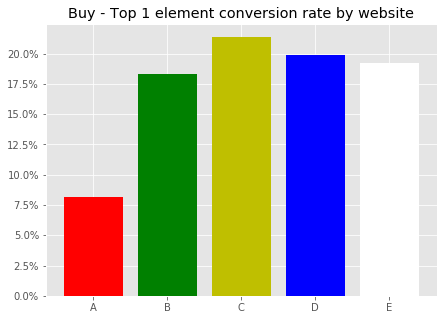

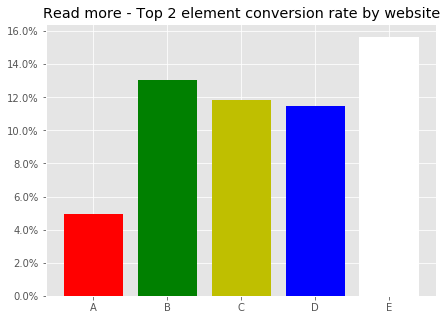

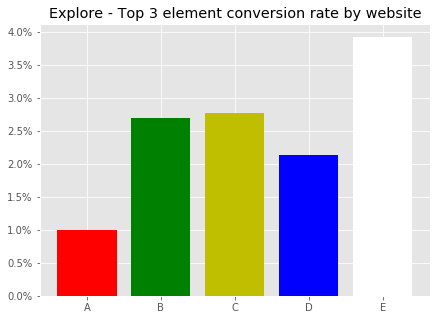

In [6]:
#Create list of Top 3 elements
top_3 = list(df_top3.sort_values('Total No. Clicks', ascending=False)['Name'].reset_index(drop=True).drop_duplicates()[:3])

#loop through elements and plot below
for idx, element in enumerate(top_3):
    #create temporary dataframes
    to_plot = df_top3[df_top3['Name'] == element][['sample_ID','conversion_rate']]
    to_plot.sort_values('sample_ID', inplace=True)
    
    #define my Y and X
    height = to_plot['conversion_rate']
    bars = to_plot['sample_ID']
    y_pos = np.arange(len(bars))
    
    #plot!!
    plt.figure(figsize=(7,5))
    plt.bar(y_pos, height, color=['r','g','y','b','w'])
    plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) #format of y axis
    plt.xticks(y_pos, bars)
    plt.title(element + ' - Top ' + str(idx+1) + ' element conversion rate by website')
    plt.show()

It's interesting to see how the conversion rate differs depending on the website and element.

Here are some conclusions:
   - Website A seems to be the worst, with the lowest conversion rates in all 3 elements. 
   - Another interesting point is the similarity between B, C and D.
   - Website E is probably the best one, it has the best numbers on the second and third most clicked elements.

However, I think it's too soon to say that E is the best option. Some could say that the difference of 21.36% conversion rate in C to 19.23% in E on element 'Buy' is small, but we need to confirm if that's statiscally relevant, so the next step is to perform a Hypothesis Test:

### Hypothesis Testing:
- H0: Conversion Rate of C is equal to Convertion Rate of E
- H1: Conversion Rate of C is different than Convertion Rate of E

Through Hypothesis Testing we can confirm whether the difference was randomly generated or not. The idea is that if we can reject the Null Hypothesis (H0), then the difference in conversion rate is relevant and so we cannot say that website E is the best option for element 'Buy'.

First, let's start by calculating the null_rate, which is the conversion rate of 'Buy' in website C, in other words, the probability of 'Buy' being clicked in website C.

In [7]:
null_rate = df_master[(df_master['sample_ID'] ==  'C') & (df_master['Name'] == 'Buy')]['conversion_rate'].values[0]/100
print('The Null Rate is: ' + str(null_rate))

The Null Rate is: 0.21368765926465236


We also need the probability in E and I'm going to also instantiate C probability in a different variable (C_prob).

In [8]:
C_prob = df_master[(df_master['sample_ID'] ==  'C') & (df_master['Name'] == 'Buy')]['conversion_rate'].values[0]/100
E_prob = df_master[(df_master['sample_ID'] ==  'E') & (df_master['Name'] == 'Buy')]['conversion_rate'].values[0]/100
print('C Conversion Rate is: ' + str(C_prob))
print('E Conversion Rate is: ' + str(E_prob))

C Conversion Rate is: 0.21368765926465236
E Conversion Rate is: 0.1923449612403101


By the way, you'll notice that C_prob and null_rate are the same, that's because the null hypothesis is testing whether C_prob = E_prob.

Now, in order to run our simulation, we need to know the total number of visits in each website.

In [9]:
n_C = df_master[(df_master['sample_ID'] ==  'C') & (df_master['Name'] == 'Buy')]['visits'].values[0]
n_E = df_master[(df_master['sample_ID'] ==  'E') & (df_master['Name'] == 'Buy')]['visits'].values[0]
print('The total number of visits in website C was ' + str(n_C))
print('The total number of visits in website E was ' + str(n_E))

The total number of visits in website C was 2747
The total number of visits in website E was 2064


#### Now it's time to simulate converted clicks:
Simulate n_E visits on page E using the null_rate 

In [10]:
#The clicks will be simulated using a random choice between 0 and 1, n_E times with a probability of null_rate for
#click and (1-null_rate) for no click.
E_page_converted = np.random.choice(2,n_E,p=[(1-null_rate),null_rate])
E_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Simulate n_C visits on page C using the null_rate

In [11]:
C_page_converted = np.random.choice(2,n_C,p=[(1-null_rate),null_rate])
C_page_converted

array([1, 0, 0, ..., 0, 0, 0])

Difference between conversion rates of E and C from simulations

In [12]:
E_page_converted.sum() / n_E - C_page_converted.sum() / n_C

0.0026385373190767614

Do 10,000 times the same simulation and store probability differences

In [13]:
p_diffs = []

for _ in range (10000):
    bootstrap_E = np.random.choice(2,n_E,p=[(1-null_rate),null_rate])
    bootstrap_C = np.random.choice(2,n_C,p=[(1-null_rate),null_rate])
    p_E = bootstrap_E.sum() / n_E
    p_C = bootstrap_C.sum() / n_C
    p_diffs.append(p_E - p_C)

Let's plot that and compare it with the observation difference we've got from the original dataset (obs_diff).

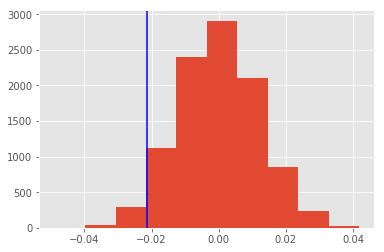

In [14]:
#convert to an array
p_diffs = np.array(p_diffs) 

#plot
plt.hist(p_diffs)
obs_diff = E_prob-C_prob
plt.axvline(x = obs_diff,color='blue');

Now we need to calculate the p-value, which is the probability of having the obs_diff or less in our simulations.

In [15]:
#Calculating p-value
pval = 1 - (p_diffs > obs_diff).mean()
print('The p-value is: ' + str(pval))

The p-value is: 0.03739999999999999


At a Type I error rate of 5%, p-value is lower than alpha, therefore we can reject the Null hypothesis and affirm that Page C has higher or equal conversion rate than Page E.

Which means that there's definitely something more about the 'Buy' element in Page C. Based on this analysis, I'd first try to understand if there are really any differences between the element in both pages, but most likely is a combination of all the elements on the page.

### Regression Analysis:

We can do the same type of analysis through Regression, so this is what we're going to do next.

On this case, I'll be using the Logit model from statsmodels.

The first step is to try the model and for that I'm going back to the dataframes we created earlier. 

In [16]:
#Create df_E and df_C dataframes and create an interpret column to train the model, this column will be the intercept
#on the linear equation.
df_E = pd.DataFrame(E_page_converted, columns=['converted'])
df_E['E_page'] = 1 #1 == it's Page E
df_C = pd.DataFrame(C_page_converted, columns=['converted'])

#Concatenate both dataframes
df = pd.concat([df_E,df_C], sort=True)
df.fillna(0, inplace=True)

#Create an interpret column, we need this to calculate the intercept of the model.
df['interpret'] = 1
df.head()

,E_page,converted,interpret
0,1.0,0,1
1,1.0,0,1
2,1.0,0,1
3,1.0,0,1
4,1.0,0,1


In [17]:
#Instantiate the model and train it
log_mod = Logit(df['converted'],df[['E_page','interpret']])
result = log_mod.fit()

#Summary of results
result.summary()

Optimization terminated successfully.
         Current function value: 0.521210
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 4811
Model:                          Logit   Df Residuals:                     4809
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 May 2019   Pseudo R-squ.:               9.671e-06
Time:                        12:43:22   Log-Likelihood:                -2507.5
converged:                       True   LL-Null:                       -2507.6
                                        LLR p-value:                    0.8257
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
E_page         0.0156      0.071      0.220      0.826      -0.123       0.154
interpret     -1.2985      0.046    -27.932      0.000      -1.390      -1.207
==============================================================================
"""

Since it's a regression analysis, the way we read the p-value is different, basically we have p-values for all components of our equation, on this case, we have two (E_page and interpret), and the null hypothesis is that the component has no effect on the calculation of Y (or total number of clicks for us). Therefore, if p-value is less than 5% it means that the we should keep the component in our equation, otherwise, it should be removed.

Therefore, based on the report above, E_page has a p-value of 0.826, which means that we can reject the null hypothesis and Page E is not a good way to predict the number of clicks.

However, I think we should run some simulations on this analysis, but this time I'll be using the Linear Regression model from sklearn.

### Regression with simulations:

In [18]:
#creating an empty list to store p-values
p_values = []

#running 10,000 simulations.
for _ in range(10000):
    #Run simulation
    E_page_converted = np.random.choice(2,n_E,p=[(1-null_rate),null_rate])
    C_page_converted = np.random.choice(2,n_C,p=[(1-null_rate),null_rate])
    
    #Create df_E and df_C dataframes and create an interpret column to train the model 
    df_E = pd.DataFrame(E_page_converted, columns=['converted'])
    df_E['E_page'] = 1 #1 == it's Page E
    df_C = pd.DataFrame(C_page_converted, columns=['converted'])

    #Concatenate both dataframes and create x and y
    df = pd.concat([df_E,df_C], sort=True)
    df.fillna(0, inplace=True)
    x = np.array(df['E_page']).reshape(-1, 1)
    y = np.array(df['converted']).reshape(-1, 1)

    #Instantiate the model and fit it
    lr_mod = LinearRegression()
    lr_mod.fit(x,y)
    
    #Get the p-value from the model and append to our list
    p_value = stats.coef_pval(lr_mod, x, y)[1]
    p_values.append(p_value)

In [19]:
#Calculate average p-value from simulations
p_values = np.array(p_values)
p_values.mean()

0.4859609177518292

Here we got the same result, p-value > 5%, therefore, we can reject the null hypothesis and confirm that Page C is better than E in number of clicks of 'Buy'.

### Conclusion

If the goal is to increase number of Buys, or number of times that the 'Buy' element was clicked, and we're between Pages C and E, we can confirm that C is the best option, even though, E had more clicks in other elements.